# 處理 outliers
* 新增欄位註記
* outliers 或 NA 填補
    1. 平均數 (mean)
    2. 中位數 (median, or Q50)
    3. 最大/最小值 (max/min, Q100, Q0)
    4. 分位數 (quantile)

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 設定 data_path
dir_data = './Part01/'

In [2]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: ./Part01/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# 如果欄位中有 NA, describe 會有問題 ???
app_train['AMT_ANNUITY'].describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

In [4]:
# Ignore NA, 計算五值
five_num = [0, 25, 50, 75, 100]
quantile_5s = [np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = i) for i in five_num]
print(quantile_5s)

[1615.5, 16524.0, 24903.0, 34596.0, 258025.5]


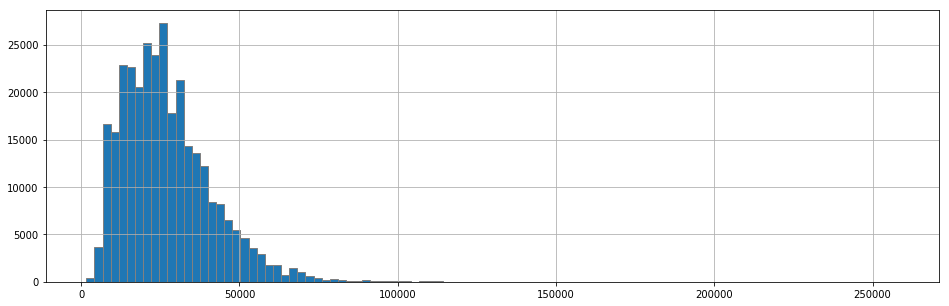

In [5]:
app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'].hist(bins = 100, figsize=(16,5), edgecolor = 'gray')
plt.show()

In [6]:
# 試著將 max 取代為 q99
app_train[app_train['AMT_ANNUITY'] == app_train['AMT_ANNUITY'].max()] = \
    np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = 99)

In [7]:
five_num = [0, 25, 50, 75, 100]
quantile_5s = [np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = i) for i in five_num]
print(quantile_5s)
quantile_5s = list(np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = five_num))
print(quantile_5s)

[1615.5, 16524.0, 24903.0, 34596.0, 230161.5]
[1615.5, 16524.0, 24903.0, 34596.0, 230161.5]


In [8]:
# 得到 median 的另外一種方法
np.median(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'])

24903.0

In [9]:
# 計算眾數 (mode)
from scipy.stats import mode
import time

start_time = time.time()
mode_get = mode(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'])
print(mode_get)
print("Elapsed time: %.3f secs" % (time.time() - start_time))

ModeResult(mode=array([9000.]), count=array([6385]))
Elapsed time: 6.209 secs


In [10]:
# 計算眾數 (mode)
# 較快速的方式
from collections import defaultdict

start_time = time.time()
# defaultdict: 調用不存在的 key時，針對此 key先建立一個 default值，這個 default值必須由一個可呼叫的函數產生
# defaultdict: 避免因 key不存在而有 KeyError
mode_dict = defaultdict(lambda:0)

# dictionary-> {value : count, ...}
for value in app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY']:
    mode_dict[value] += 1

# dict.items() return a list of a given dictionary’s (key, value) tuple pair
# key = lambda kv: kv[1] -> sorted by the second element of the tuple pair, i.e. value
mode_get = sorted(mode_dict.items(), key=lambda kv: kv[1], reverse=True)
print(mode_get[0])
print("Elapsed time: %.3f secs" % (time.time() - start_time))

(9000.0, 6385)
Elapsed time: 0.344 secs


## 連續值標準化
### 1. Z-transform: $ \frac{(x - mean(x))}{std(x)} $
### 2. Range (0 ~ 1): $ \frac{x - min(x)}{max(x) - min(x)} $
### 3. Range (-1 ~ 1): $ (\frac{x - min(x)}{max(x) - min(x)} - 0.5) * 2 $

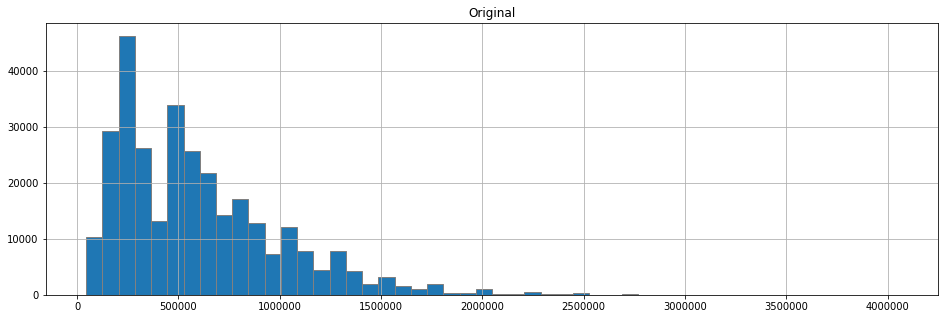

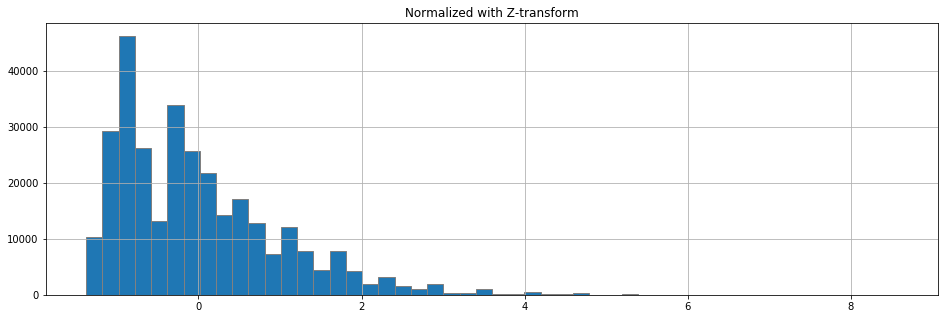

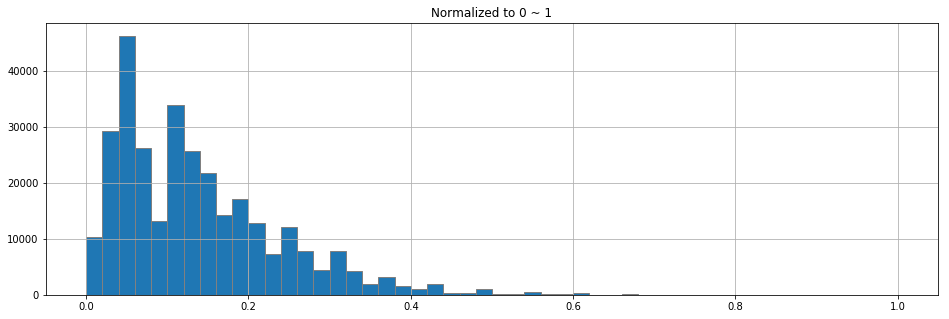

In [11]:
# 以 AMT_CREDIT 為例
app_train['AMT_CREDIT'].hist(bins = 50, figsize=(16,5), edgecolor = 'gray')
plt.title("Original")
plt.show()
value = app_train['AMT_CREDIT'].values

app_train['AMT_CREDIT_Norm1'] = ( value - np.mean(value) ) / ( np.std(value) )
app_train['AMT_CREDIT_Norm1'].hist(bins = 50, figsize=(16,5), edgecolor = 'gray')
plt.title("Normalized with Z-transform")
plt.show()

app_train['AMT_CREDIT_Norm2'] = ( value - min(value) ) / ( max(value) - min(value) )
app_train['AMT_CREDIT_Norm2'].hist(bins = 50, figsize=(16,5), edgecolor = 'gray')
plt.title("Normalized to 0 ~ 1")
plt.show()

# 作業

## 1. 列出 AMT_ANNUITY 的 q0 - q100
## 2.1 將 AMT_ANNUITY 中的 NAs 暫時以中位數填補
## 2.2 將 AMT_ANNUITY 的數值標準化至 -1 ~ 1 間
## 3. 將 AMT_GOOD_PRICE 的 NAs 以眾數填補


In [12]:
# 重新讀取資料
app_train = pd.read_csv(f_app)

In [13]:
# 1: 計算 AMT_ANNUITY 的 q0 - q100
q_all = np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = range(101))

qtable = pd.DataFrame({'q': list(range(101)), 'value': q_all})
qtable

,q,value
0,0,1615.50
1,1,6182.91
2,2,6750.00
3,3,7875.00
4,4,8703.00
5,5,9000.00
6,6,9000.00
7,7,9553.50
8,8,10125.00
9,9,10503.00


In [14]:
# 2.1 將 NAs 以 q50 填補
print("Before replace NAs, numbers of row that AMT_ANNUITY is NAs: %i" % sum(app_train['AMT_ANNUITY'].isnull()))

# q_50 = np.median(app_train.loc[~app_train['AMT_ANNUITY'].isnull(),'AMT_ANNUITY'])
q_50 = qtable.iloc[50, 1]
app_train.loc[app_train['AMT_ANNUITY'].isnull(),'AMT_ANNUITY'] = q_50

print("After replace NAs, numbers of row that AMT_ANNUITY is NAs: %i" % sum(app_train['AMT_ANNUITY'].isnull()))

Before replace NAs, numbers of row that AMT_ANNUITY is NAs: 12
After replace NAs, numbers of row that AMT_ANNUITY is NAs: 0


### Hints: Normalize function (to -1 ~ 1)
$ y = 2*(\frac{x - min(x)}{max(x) - min(x)} - 0.5) $

== Original data range ==
count    307511.000000
mean      27108.487841
std       14493.461065
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

== Normalized data range ==
count    307511.000000
mean         -0.801154
std           0.113049
min          -1.000000
25%          -0.883714
50%          -0.818357
75%          -0.742752
max           1.000000
Name: AMT_ANNUITY_NORMALIZED, dtype: float64


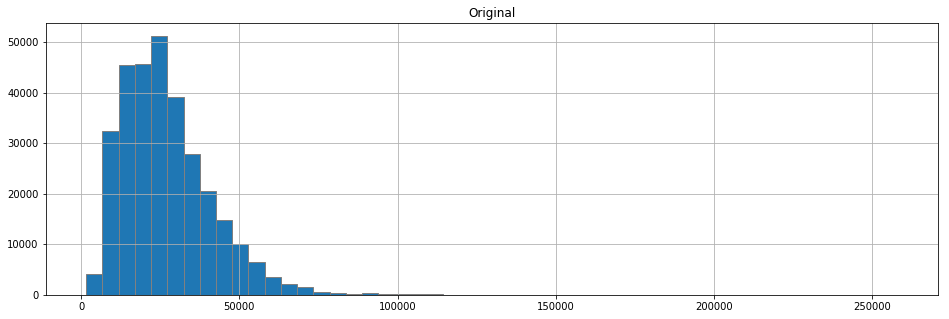

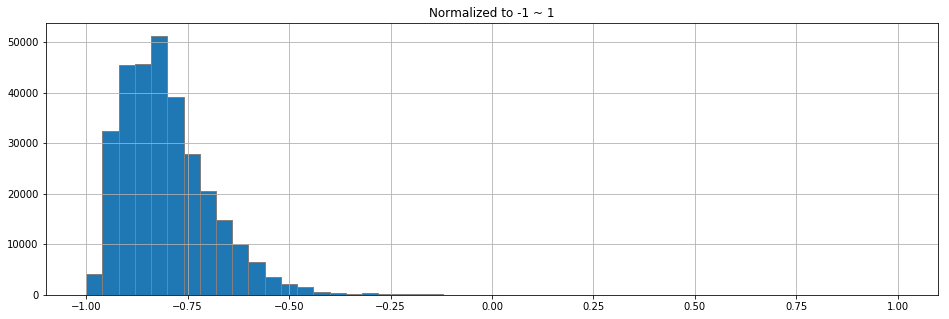

In [15]:
# 2.2 Normalize values to -1 to 1
print("== Original data range ==")
print(app_train['AMT_ANNUITY'].describe())

def normalize_value(x):
    x = 2 * ((x-min(x))/(max(x)-min(x))-0.5)
    return x

app_train['AMT_ANNUITY_NORMALIZED'] = normalize_value(app_train['AMT_ANNUITY'])

print("")
print("== Normalized data range ==")
print(app_train['AMT_ANNUITY_NORMALIZED'].describe())

app_train['AMT_ANNUITY'].hist(bins = 50, figsize=(16,5), edgecolor = 'gray')
plt.title("Original")
plt.show()
app_train['AMT_ANNUITY_NORMALIZED'].hist(bins = 50, figsize=(16,5), edgecolor = 'gray')
plt.title("Normalized to -1 ~ 1")
plt.show()

In [16]:
# 3 將 AMT_GOODS_PRICE 的 NAs 以眾數填補
print("Before replace NAs, numbers of row that AMT_GOODS_PRICE is NAs: %i" % sum(app_train['AMT_GOODS_PRICE'].isnull()))

# 列出重複最多的數值
mode_dict = defaultdict(lambda:0)

for value in app_train[~app_train['AMT_GOODS_PRICE'].isnull()]['AMT_GOODS_PRICE']:
    mode_dict[value] += 1

value_most = sorted(mode_dict.items(), key = lambda kv: kv[1], reverse = True)[0]
print(value_most)

mode_goods_price = list(app_train['AMT_GOODS_PRICE'].value_counts().index)
print(mode_goods_price[0])
app_train.loc[app_train['AMT_GOODS_PRICE'].isnull(), 'AMT_GOODS_PRICE'] = mode_goods_price[0]

print("After replace NAs, numbers of row that AMT_GOODS_PRICE is NAs: %i" % sum(app_train['AMT_GOODS_PRICE'].isnull()))

Before replace NAs, numbers of row that AMT_GOODS_PRICE is NAs: 278
(450000.0, 26022)
450000.0
After replace NAs, numbers of row that AMT_GOODS_PRICE is NAs: 0
